# 1. Please click **"Sign in"** in the right upper corner to login with any google account.

# 2. Please click **"Connect"** in the right upper corner to start the remote server.

# 3. Please find the menu in the left upper corner and click **"Runtime"** -> **"Run all"** to start the notebook. 

# 4. Meanwhile, you will be required to **login** your google account again in the **4th cell**. Please click the link and login, then copy the **code** shown on the new webpage and paste it into the 4th cell. 

# 5. After waiting for 1~2 minutes (depending on the network speed), scroll to the **bottom** and you will see an random abstract possibly related to coronavirus. The keywords are listed on the top and also hightlighted in the abstract. Please adjust the **"Keywords \#"** and **"Score threshold"** to test until the generated keywords are fine to you. Click **"Submit hyperparameters"** and the hyperparameters you selected will be recorded in the database. A new abstract will be displayed and please repeat the movements of adjustment and submission. 

# 6. By doing this, you will help us know which configuration is more reliable for an expert. We will use the averaged configuration to generate keywords for all the other papers. The task of keywords extraction is inherently difficult so the program might not be as smart as human. Therefore, please feel free to send feedback to me (tanjin_he@berkeley.edu) if you have any question or suggestion. We will try our best to improve. Thank you very much!  


In [0]:
# jupyter notebook to run on Colab

In [0]:
import os

script_dir = '/content/KeywordsExtraction'
if not os.path.exists(script_dir):
    os.makedirs(script_dir)

In [3]:
%cd /content/KeywordsExtraction

/content/KeywordsExtraction


In [4]:
# download data and script files
from google.colab import auth
import gdown
auth.authenticate_user()  # must authenticate

'''list all ids of files directly under folder folder_id'''
def folder_list(folder_id):
    from googleapiclient.discovery import build
    gdrive = build('drive', 'v3').files()
    res = gdrive.list(q="'%s' in parents" % folder_id).execute()
    return [f['id'] for f in res['files']]

'''download all files from a gdrive folder to current directory'''
def folder_download(folder_id):
    for fid in folder_list(folder_id):
        url = 'https://drive.google.com/uc?id=' + fid
        gdown.download(url, None, False)
        # !gdown -q --id $fid

folder_download('10O49RiLsYi3ekcf2KCHml9hYIus_ecor')


Downloading...
From: https://drive.google.com/uc?id=1FVNI7hwUhpjxSjTP4SFLO-xVS91yb8ie
To: /content/KeywordsExtraction/keyword_extraction_tuning.ipynb
100%|██████████| 29.9k/29.9k [00:00<00:00, 7.11MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZusNCESvc_EzzN_v1WLSRY0qtH9SRf9q
To: /content/KeywordsExtraction/paper_samples_21181.json
32.5MB [00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1f43VyfXpaAYQMoVamuW1R4EtCvzu3j
To: /content/KeywordsExtraction/paper_samples.json
100%|██████████| 835k/835k [00:00<00:00, 70.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4nAatRmbJhyeonPwbxwDC1SRc-rqGV8
To: /content/KeywordsExtraction/config_clever_cloud.json
100%|██████████| 220/220 [00:00<00:00, 62.4kB/s]
Downloading...
From: https://drive.google.com/uc?id=1-5hjv6-U3V_2cpfEEu9AC3SVuOt6Z79H
To: /content/KeywordsExtraction/keywords_test.html
100%|██████████| 715k/715k [00:00<00:00, 99.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-_T7uaONV

In [5]:
!pip install summa
!pip install yake
!pip install git+https://github.com/boudinfl/pke.git
!python -m nltk.downloader stopwords
!python -m nltk.downloader punkt
!python -m nltk.downloader universal_tagset
!python -m spacy download en 
!pip install mrakun

  Cloning https://github.com/boudinfl/pke.git to /tmp/pip-req-build-_0pcblkl
  Running command git clone -q https://github.com/boudinfl/pke.git /tmp/pip-req-build-_0pcblkl
  Created wheel for pke: filename=pke-1.8.1-cp36-none-any.whl size=8757320 sha256=a39eb8c7460082fadd039035b359ad5b595df4d6cd7db3bc9bb9480274679fd5
  Stored in directory: /tmp/pip-ephem-wheel-cache-fmmaavea/wheels/8d/24/54/6582e854e9e32dd6c632af6762b3a5d2f6b181c2992e165462
Successfully built pke
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may res

Imported BH algo


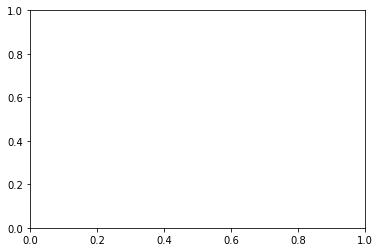

In [6]:
import random
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output, Javascript
from ipywidgets import interact
import json
from pprint import pprint
from datetime import datetime
import socket

from keywords_extraction import *


In [7]:
from common_utils import get_mongo_db

db = get_mongo_db('config_clever_cloud.json')
print(db.collection_names())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  after removing the cwd from sys.path.


['kw_extraction_tuning']


In [0]:
in_path = 'paper_samples_21181.json'
with open(in_path, 'r') as fr:
    data = json.load(fr)

doi_abstract = {doc['doi']: doc['abstract'] for doc in data}
all_dois = [doc['doi'] for doc in data]
doi_to_display = None

style = {'description_width': '100px'}
layout = widgets.Layout(width='auto', height='40px') #set width and height

num_keywords_widget = widgets.IntSlider(
    min=1, 
    max=50, 
    step=1, 
    value=10,
    description='Keywords #',
    style=style,
)
score_threshold_widget = widgets.FloatSlider(
    min=0.0, 
    max=0.3, 
    step=0.01, 
    value=0.0,
    description='Score threshold',
    style=style,
)
submit_widget = widgets.Button(
    description='Submit hyperparameters',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Submit',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=layout,
)
skip_widget = widgets.Button(
    description='Skip this paper',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Skip',
    icon='check', # (FontAwesome names without the `fa-` prefix)
    layout=layout,
)

In [0]:
hyperparameter = {
        'name': 'RaKUn',
        'distance_threshold': 2,
        'pair_diff_length': 2,
        'bigram_count_threhold': 2,
        'num_tokens': [1,2,3],
        'max_similar': 10,
        'max_occurrence': 3,
        'num_keywords': 10,
        'score_threshold': 0.0,
        'use_longest_phrase': True,
}

def display_keywords(num_keywords=10, 
                     score_threshold=0.0):
    global doi_to_display
    global hyperparameter
    if doi_to_display is None:
        doi_to_display = random.choice(all_dois)
    abstract = doi_abstract[doi_to_display]
    abstract = KeywordsExtractorBase().clean_html_tag(abstract)
    hyperparameter['num_keywords'] = num_keywords
    hyperparameter['score_threshold'] = score_threshold
    extractor = KeywordsExtractorRaKUn(
        **hyperparameter
    )
    keywords = extractor.process(abstract)
    html_body = ''
    html_body += '<div style="background-color:#dbe9ea3d; font-size:20px;">\n'
    html_body += '<p>doi: {}</p>\n'.format(doi_to_display)
    html_body += '<p>keyword extractor: {}</p>\n'.format(extractor.name)
    html_body += '<p>keywords: {}</p>\n'.format(', '.join(keywords))
    html_body += '<p>{}</p>\n'.format(
                    extractor.hightlight_keywords(
                    keywords=keywords,
                    text=abstract,
                    light_color='#ffea593d',
                    deep_color='#ffc107',
                )
            )
    html_body += '</div>\n'
    display(HTML(html_body))

def show_interactive():
    display(submit_widget)
    display(skip_widget)
    interact(
        display_keywords,
        num_keywords=num_keywords_widget, 
        score_threshold=score_threshold_widget,
    )

def on_submit_clicked(_):
    global doi_to_display
    global hyperparameter
    doi_to_display = None
    db['kw_extraction_tuning'].insert_one(
        {
            'hyperparameter': hyperparameter,
            'last_updated': datetime.now(),
            'agent': '{}@{}'.format(
                socket.gethostname(),
                socket.gethostbyname(socket.gethostname())
            ),
        }
    )
    clear_output()
    show_interactive()
    print('there')

def on_skip_clicked(_):
    global doi_to_display
    doi_to_display = None
    clear_output()
    show_interactive()
    print('here')


submit_widget.on_click(on_submit_clicked)
skip_widget.on_click(on_skip_clicked)
show_interactive()

Button(description='Submit hyperparameters', icon='check', layout=Layout(height='40px', width='auto'), style=B…

Button(description='Skip this paper', icon='check', layout=Layout(height='40px', width='auto'), style=ButtonSt…

interactive(children=(IntSlider(value=10, description='Keywords #', max=50, min=1, style=SliderStyle(descripti…

there
